Data Loading Phase

In [ ]:
!pip install pandas

In [ ]:
!pip install numpy

In [ ]:
!pip install matplotlib

In [ ]:
!pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("dataset.csv")
print(df.isna().sum())
print(df.head())

age         51
sex          0
cp           0
trestbps    51
chol        13
fbs          0
restecg      0
thalach     17
exang        0
oldpeak      1
slope        0
ca          51
thal        51
target       0
dtype: int64
    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1  53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2  70.0    1   0     145.0  174.0    0        1    125.0      1      2.6   
3  61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
4  62.0    0   0     138.0  294.0    1        1    106.0      0      1.9   

   slope   ca  thal  target  
0      2  2.0   3.0       0  
1      0  0.0   3.0       0  
2      0  0.0   3.0       0  
3      2  1.0   3.0       0  
4      1  NaN   NaN       0  


Handling Missing and Noisy Values

In [13]:
def knn_impute(df, k=3):
    df_imputed = df.copy()
    data = df.values

    for i in range(len(data)):
        row = data[i]
        if np.any(np.isnan(row)):
            distances = []
            for j in range(len(data)):
                if i == j:
                    continue
                other = data[j]
                mask = ~np.isnan(row) & ~np.isnan(other)
                if np.sum(mask) == 0:
                    continue
                dist = np.sqrt(np.sum((row[mask] - other[mask]) ** 2))
                distances.append((dist, j))

            distances.sort(key=lambda x: x[0])
            neighbors_idx = [j for _, j in distances[:k]]

            for col in range(data.shape[1]):
                if np.isnan(row[col]):
                    vals = [data[j, col] for j in neighbors_idx if not np.isnan(data[j, col])]
                    if vals:
                        df_imputed.iat[i, col] = np.mean(vals)
    return df_imputed

def knn_impute_weighted(df, k=3, epsilon=1e-5):
    df_imputed = df.copy()
    data = df.values

    for i in range(len(data)):
        row = data[i]
        if np.any(np.isnan(row)):
            distances = []
            for j in range(len(data)):
                if i == j:
                    continue
                other = data[j]
                mask = ~np.isnan(row) & ~np.isnan(other)
                if np.sum(mask) == 0:
                    continue
                dist = np.sqrt(np.sum((row[mask] - other[mask]) ** 2))
                distances.append((dist, j))

            # sort and select k nearest
            distances.sort(key=lambda x: x[0])
            neighbors = distances[:k]

            for col in range(data.shape[1]):
                if np.isnan(row[col]):
                    vals, weights = [], []
                    for dist, j in neighbors:
                        val = data[j, col]
                        if not np.isnan(val):
                            # inverse distance as weight (closer => higher weight)
                            w = 1.0 / (dist + epsilon)
                            vals.append(val)
                            weights.append(w)
                    if vals:
                        weighted_avg = np.average(vals, weights=weights)
                        df_imputed.iat[i, col] = weighted_avg
    return df_imputed


def remove_outliers_iqr(df, exclude_cols=[]):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in exclude_cols:
            continue

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after = len(df_clean)

        print(f"{col}: removed {before - after} outliers")

    return df_clean

In [14]:
# df_imputed = knn_impute(df, k=3)
df = remove_outliers_iqr(df, exclude_cols=['target', 'sex', 'fbs', 'exang'])
df_imputed = knn_impute_weighted(df, k=3)
print(df_imputed.isna().sum())
print(df_imputed)

age: removed 51 outliers
cp: removed 0 outliers
trestbps: removed 71 outliers
chol: removed 25 outliers
restecg: removed 0 outliers
thalach: removed 17 outliers
oldpeak: removed 12 outliers
slope: removed 0 outliers
ca: removed 103 outliers
thal: removed 5 outliers
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
       age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1     53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2     70.0    1   0     145.0  174.0    0        1    125.0      1      2.6   
3     61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
5     58.0    0   0     100.0  248.0    0        0    122.0      0      1.0   
...    ...  ...  ..       ...    ...  ...      ... 

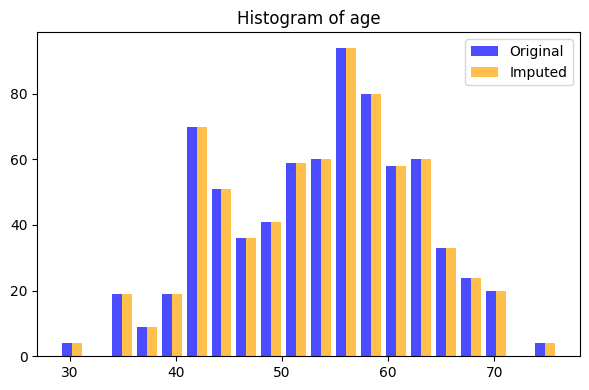

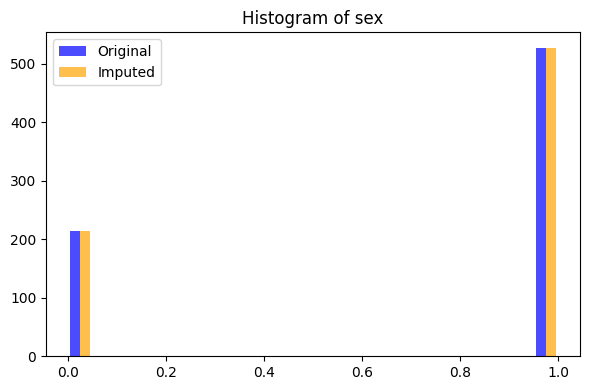

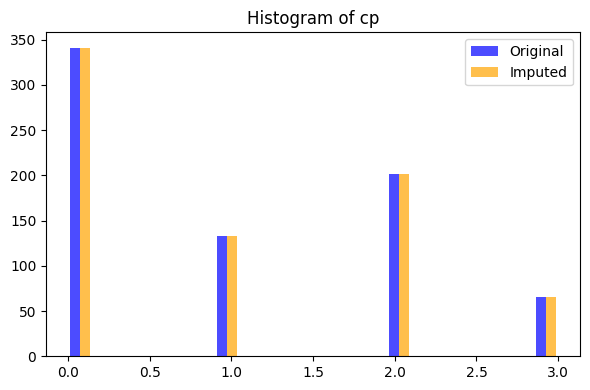

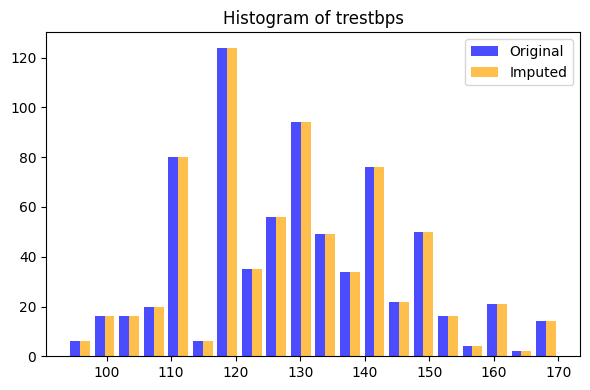

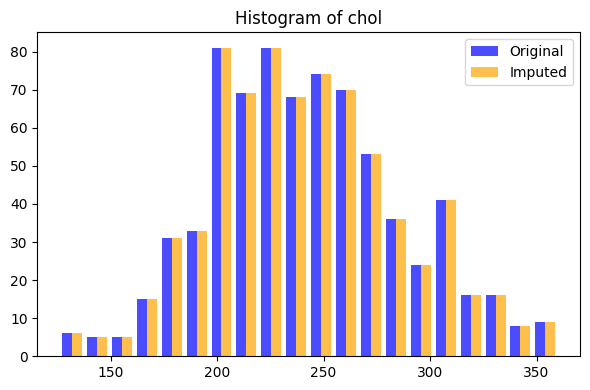

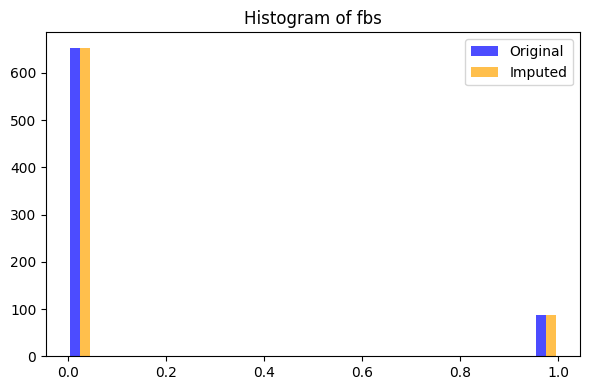

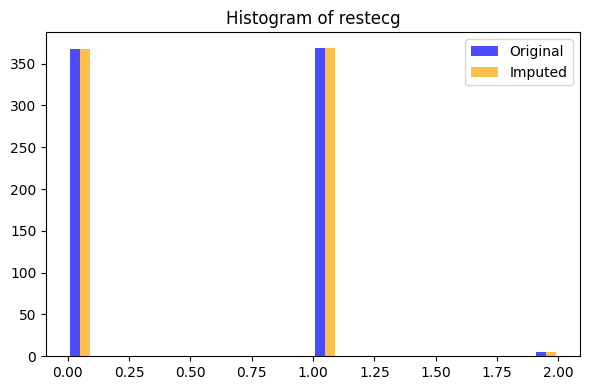

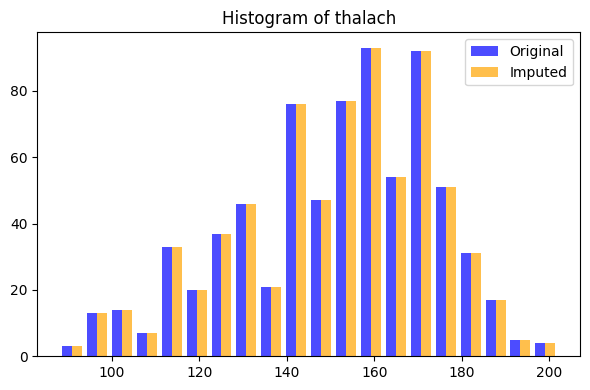

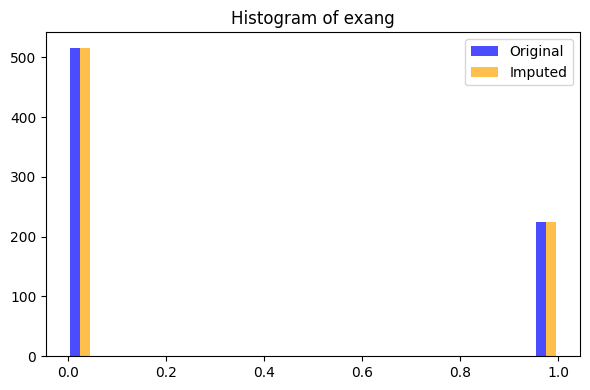

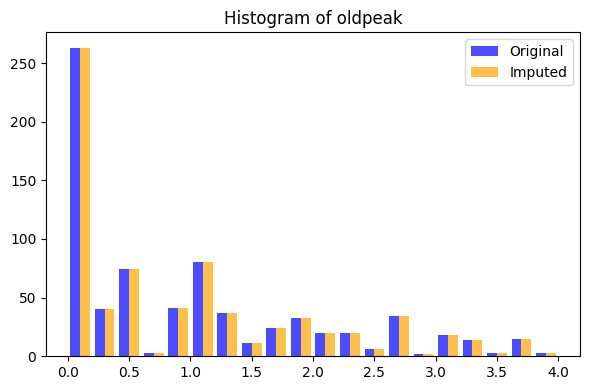

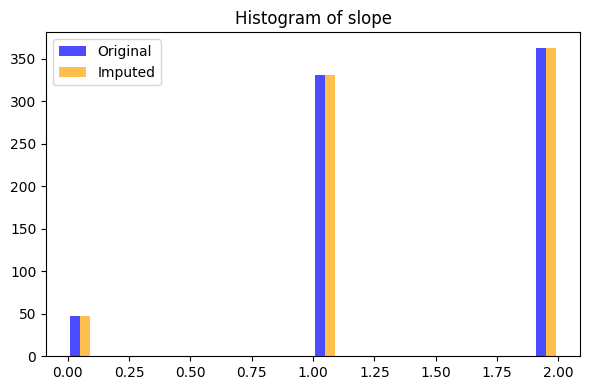

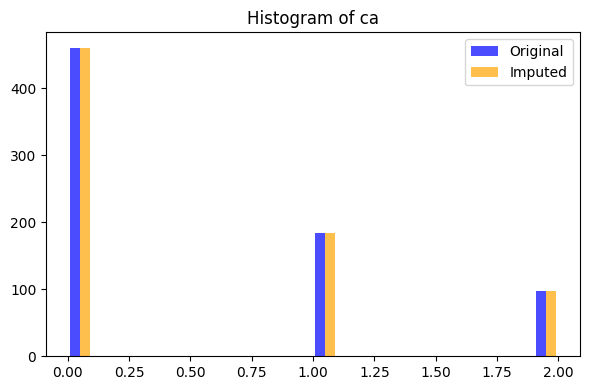

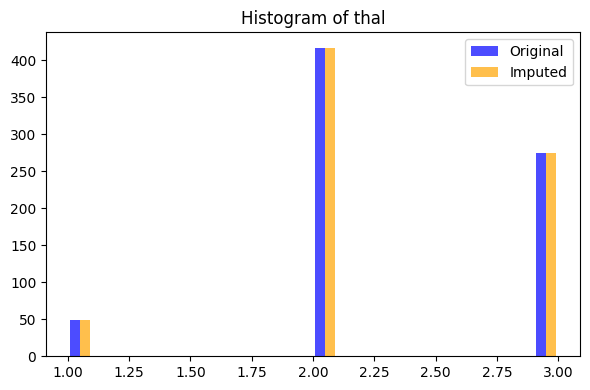

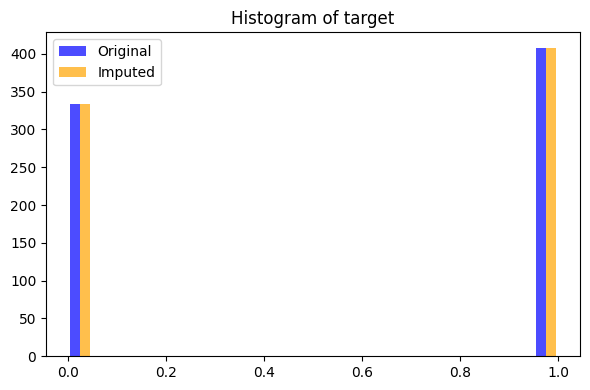

In [15]:
for col in df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist([df[col].dropna(), df_imputed[col]],
             bins=20,
             label=['Original', 'Imputed'],
             color=['blue', 'orange'],
             alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Normalization

In [16]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
df_scaled[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
print(df_scaled.describe())

                age           sex            cp      trestbps          chol  \
count  7.410000e+02  7.410000e+02  7.410000e+02  7.410000e+02  7.410000e+02   
mean  -3.116416e-16 -1.270539e-16  4.315037e-17 -4.027368e-16  1.630125e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.739502e+00 -1.568213e+00 -9.483759e-01 -2.254876e+00 -2.610071e+00   
25%   -8.478445e-01 -1.568213e+00 -9.483759e-01 -5.827910e-01 -7.397567e-01   
50%    1.536211e-01  6.368077e-01  1.166036e-02  6.031865e-02 -6.373962e-02   
75%    7.099910e-01  6.368077e-01  9.716966e-01  7.034283e-01  6.122775e-01   
max    2.490374e+00  6.368077e-01  1.931733e+00  2.632757e+00  2.662863e+00   

                fbs       restecg       thalach         exang       oldpeak  \
count  7.410000e+02  7.410000e+02  7.410000e+02  7.410000e+02  7.410000e+02   
mean   1.438346e-17 -1.054787e-16 -4.027368e-16  7.791039e-17 -1.354442e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

Exploratory Data Analysis (EDA)

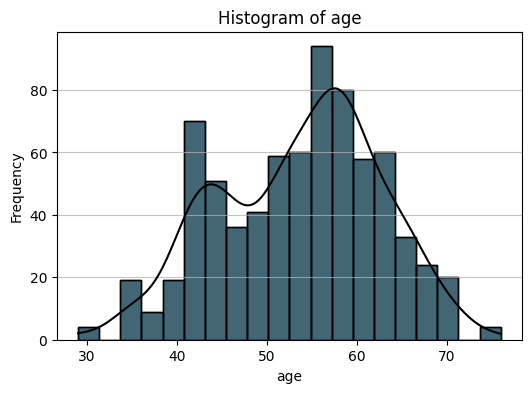

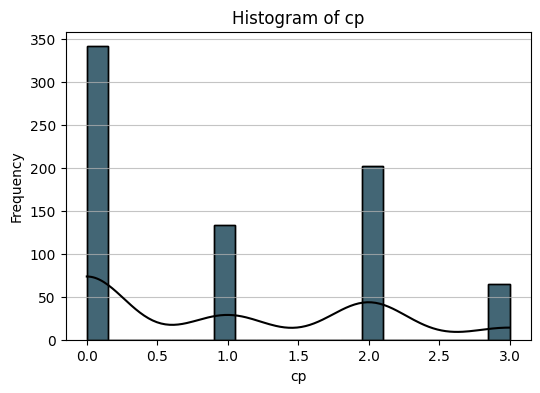

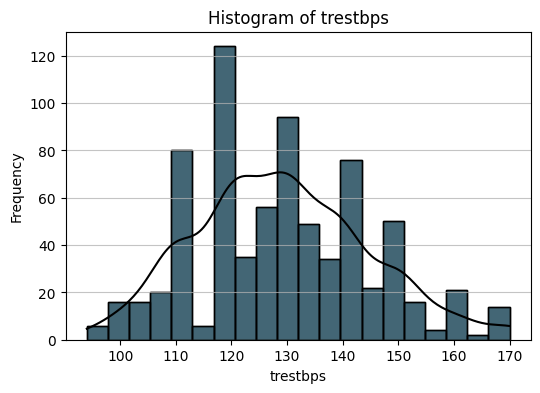

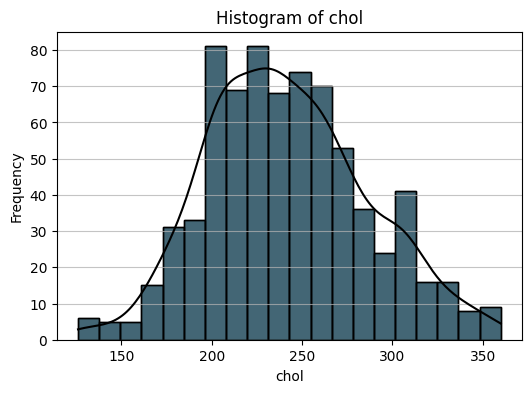

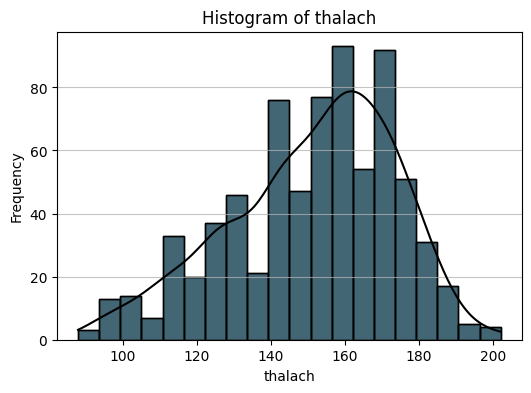

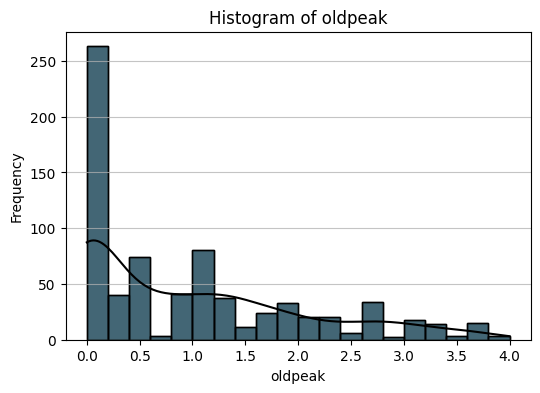

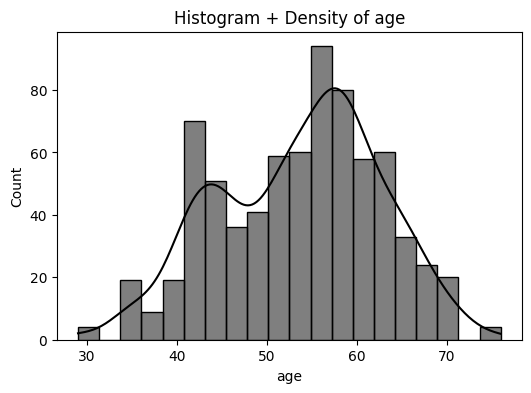

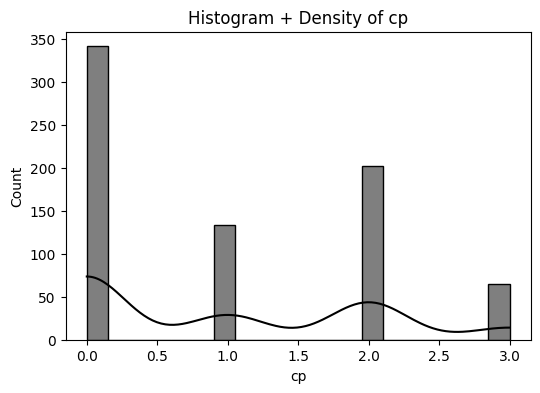

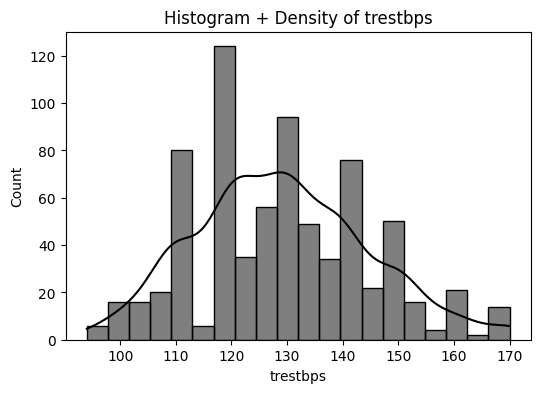

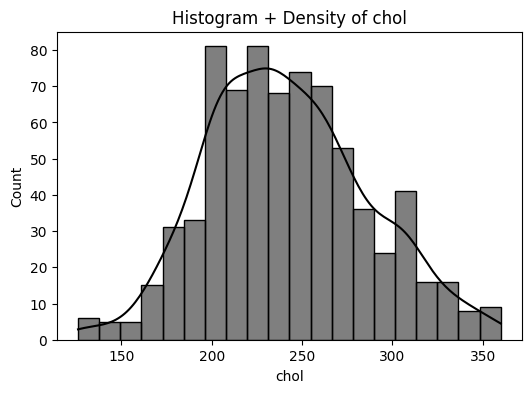

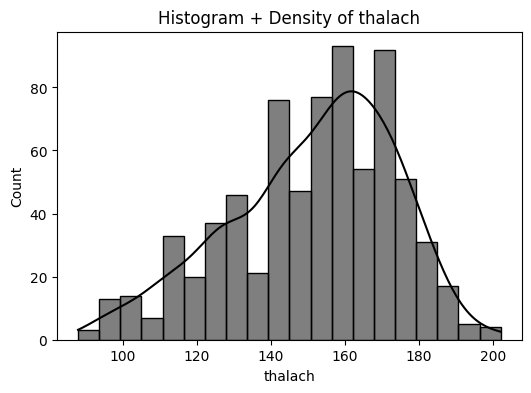

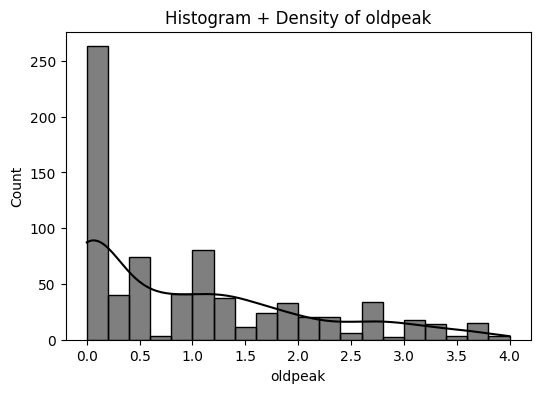

In [17]:

exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram + Density of {col}')
    plt.show()

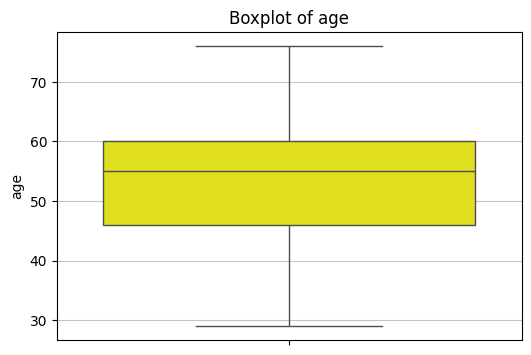

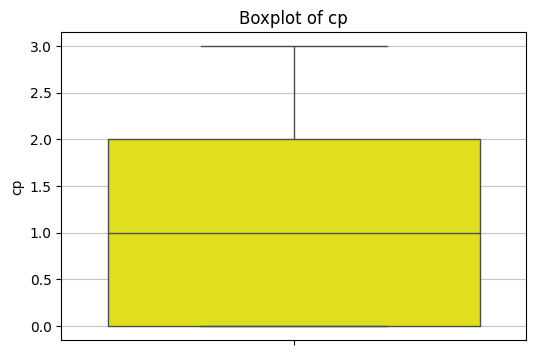

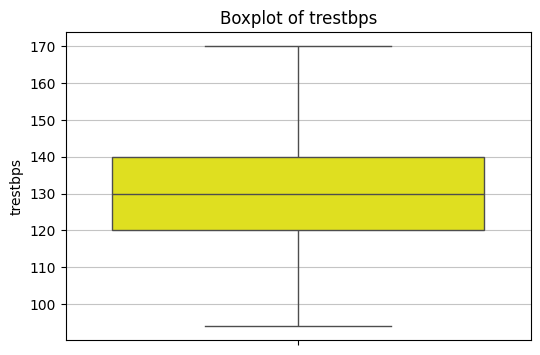

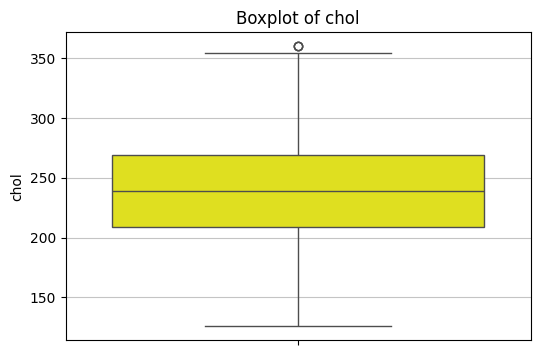

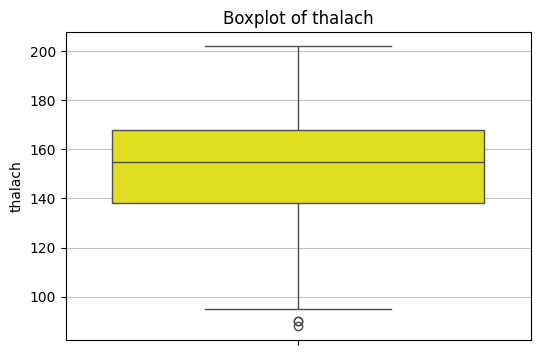

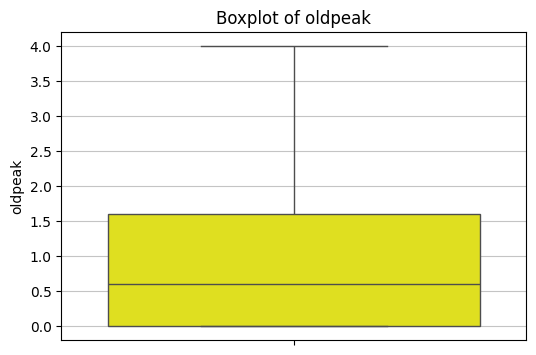

In [18]:
exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col], color='yellow')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

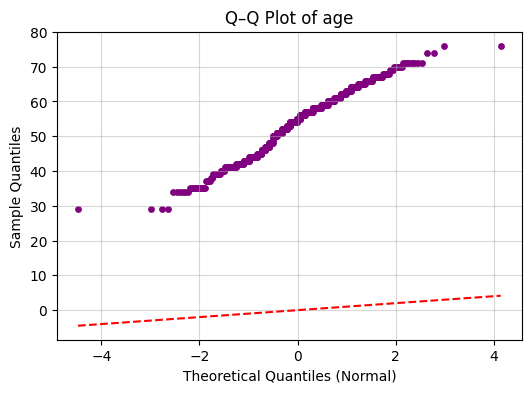

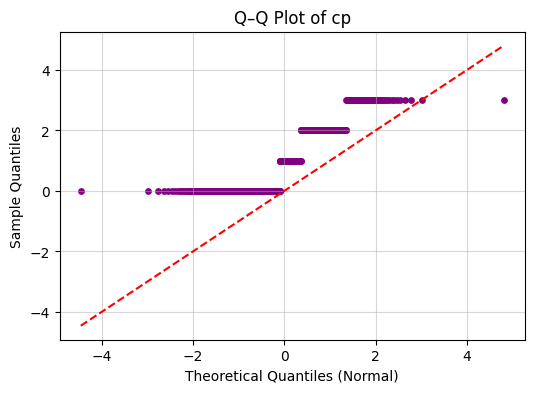

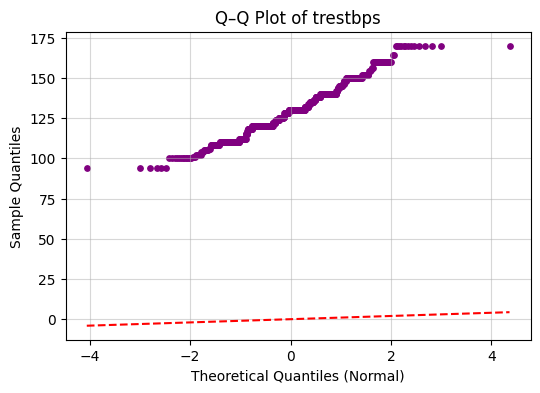

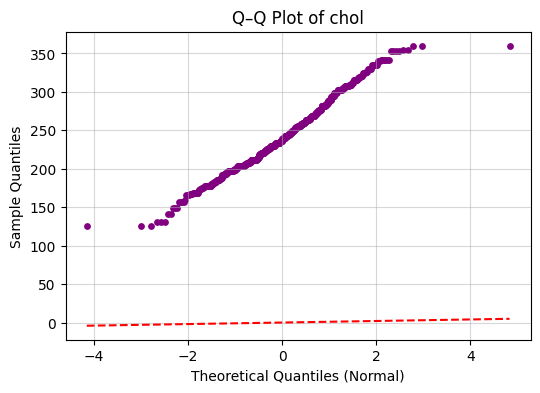

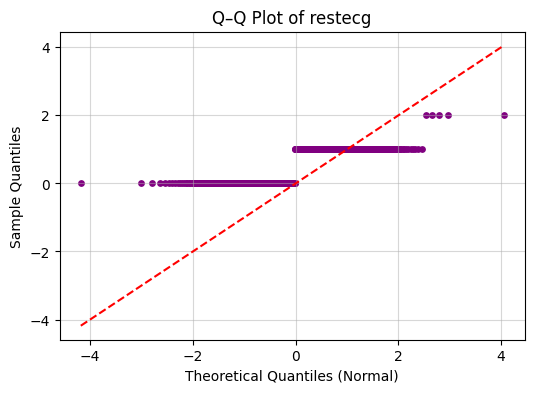

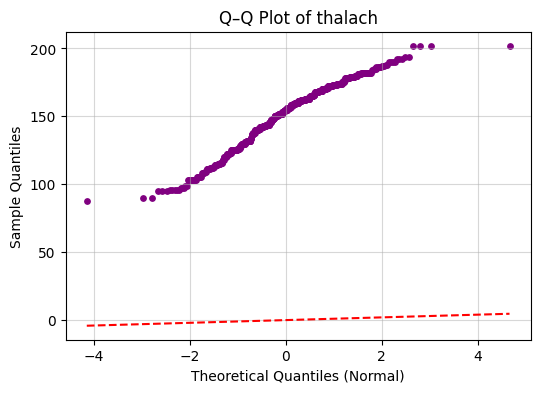

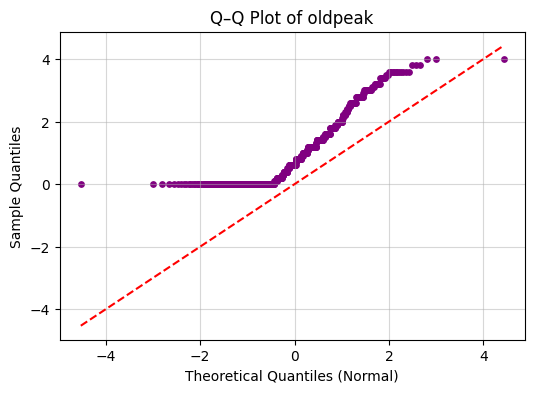

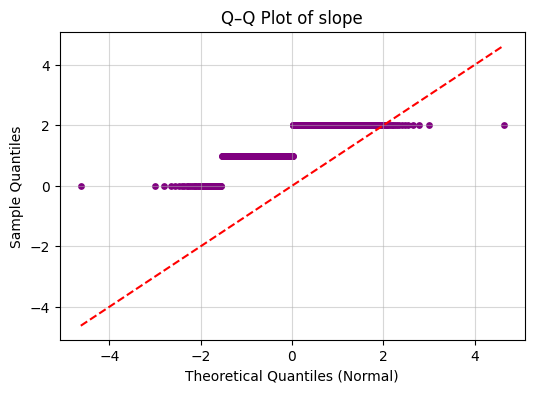

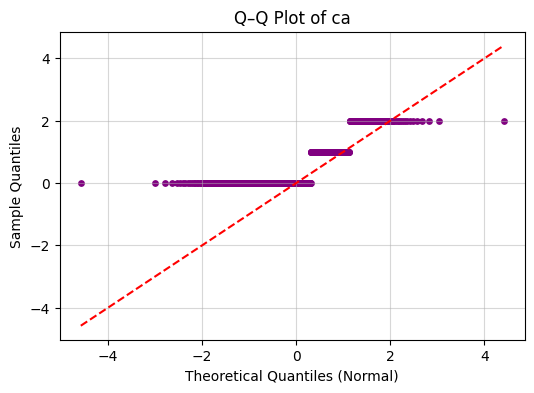

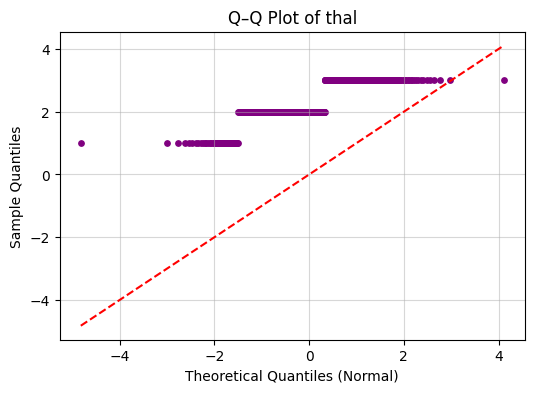

In [19]:
exclude_cols = ['target', 'exang', 'fbs', 'sex']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols]
def normal_quantiles(size):
    return np.quantile(np.random.normal(0, 1, 100000), np.linspace(0, 1, size))

for col in numeric_cols:
    data = df[col].dropna().values
    data_sorted = np.sort(data)
    theoretical = normal_quantiles(len(data_sorted))

    plt.figure(figsize=(6, 4))
    plt.scatter(theoretical, data_sorted, color='purple', s=15)
    plt.plot(theoretical, theoretical, color='red', linestyle='--')
    plt.title(f'Q–Q Plot of {col}')
    plt.xlabel('Theoretical Quantiles (Normal)')
    plt.ylabel('Sample Quantiles')
    plt.grid(True, alpha=0.5)
    plt.show()

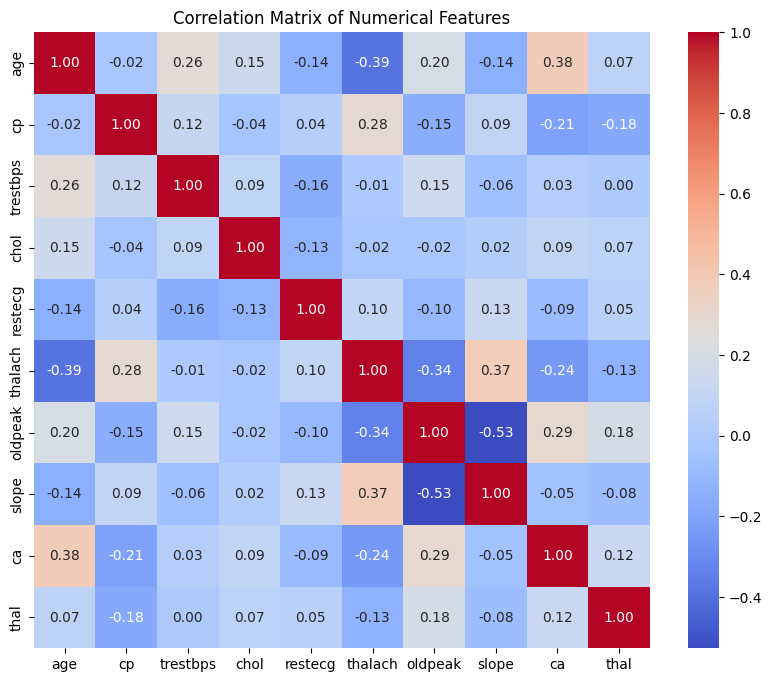

In [20]:
exclude_cols = ['target', 'exang', 'fbs', 'sex']

numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Most features are reasonably independent, which is good for KNN — each contributes differently to distance calculations.

Train and Test the Model

In [21]:
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy()

np.random.seed(42)
indices = np.arange(len(df))
np.random.shuffle(indices)

train_size = int(0.8 * len(df))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 592
Test size: 149


In [22]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict_weighted(X_train, y_train, X_test, k=5):
    y_pred = []
    for test_point in X_test:
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        nn_indices = distances.argsort()[:k]
        nn_labels = y_train[nn_indices]
        nn_distances = distances[nn_indices]
        # weight = 1 / distance (avoid div by 0)
        weights = 1 / (nn_distances + 1e-5)
        # vote with weights
        label_weights = {}
        for label, w in zip(nn_labels, weights):
            label_weights[label] = label_weights.get(label, 0) + w
        y_pred.append(max(label_weights, key=label_weights.get))
    return np.array(y_pred)

best_k = 1
best_acc = 0
for k in range(1, 21, 2):  # odd numbers to avoid ties
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc = np.mean(y_pred == y_test)
    print(f"k={k}, accuracy={acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k
print("Best k:", best_k, "with accuracy:", best_acc)


k=1, accuracy=0.966
k=3, accuracy=0.966
k=5, accuracy=0.966
k=7, accuracy=0.966
k=9, accuracy=0.966
k=11, accuracy=0.987
k=13, accuracy=0.987
k=15, accuracy=0.987
k=17, accuracy=0.987
k=19, accuracy=0.987
Best k: 11 with accuracy: 0.9865771812080537


In [23]:

def compute_metrics(y_true, y_pred):
    """
    Works for binary classification (labels 0 and 1)
    Returns accuracy, precision, recall, f1-score
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy, precision, recall, f1

rows = []
for k in range(1, 21, 2):
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    rows.append({
        'k': k,
        'Accuracy': round(acc, 3),
        'Precision': round(prec, 3),
        'Recall': round(rec, 3),
        'F1-score': round(f1, 3)
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

    k  Accuracy  Precision  Recall  F1-score
0   1     0.966        1.0   0.942     0.970
1   3     0.966        1.0   0.942     0.970
2   5     0.966        1.0   0.942     0.970
3   7     0.966        1.0   0.942     0.970
4   9     0.966        1.0   0.942     0.970
5  11     0.987        1.0   0.977     0.988
6  13     0.987        1.0   0.977     0.988
7  15     0.987        1.0   0.977     0.988
8  17     0.987        1.0   0.977     0.988
9  19     0.987        1.0   0.977     0.988


Apply K-Fold Cross-Validation

In [24]:
def k_fold_cross_validation(X, y, k_neighbors=5, n_splits=5, weighted=True):
    """
    Perform K-Fold CV for KNN
    X: features (numpy array)
    y: labels (numpy array)
    k_neighbors: number of neighbors for KNN
    n_splits: number of folds
    weighted: whether to use weighted KNN
    Returns: average metrics across folds
    """
    fold_size = len(X) // n_splits
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    accuracies, precisions, recalls, f1s = [], [], [], []

    for i in range(n_splits):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        if weighted:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)
        else:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)

        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    return {
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1-score': np.mean(f1s)
    }

k_values = range(1, 21, 2)
rows = []

for k in k_values:
    metrics = k_fold_cross_validation(X_train, y_train, k_neighbors=k, n_splits=5)
    rows.append({
        'k': k,
        'Accuracy': round(metrics['Accuracy'], 3),
        'Precision': round(metrics['Precision'], 3),
        'Recall': round(metrics['Recall'], 3),
        'F1-score': round(metrics['F1-score'], 3)
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

    k  Accuracy  Precision  Recall  F1-score
0   1     0.931      0.922   0.954     0.938
1   3     0.932      0.939   0.937     0.937
2   5     0.954      0.960   0.957     0.958
3   7     0.929      0.930   0.935     0.932
4   9     0.942      0.944   0.950     0.946
5  11     0.949      0.951   0.956     0.953
6  13     0.936      0.950   0.931     0.940
7  15     0.910      0.921   0.916     0.918
8  17     0.927      0.937   0.928     0.932
9  19     0.936      0.959   0.916     0.937


Elbow Method

k=1, CV Error=0.024
k=3, CV Error=0.019
k=5, CV Error=0.027
k=7, CV Error=0.024
k=9, CV Error=0.039
k=11, CV Error=0.036
k=13, CV Error=0.026
k=15, CV Error=0.030
k=17, CV Error=0.019
k=19, CV Error=0.042


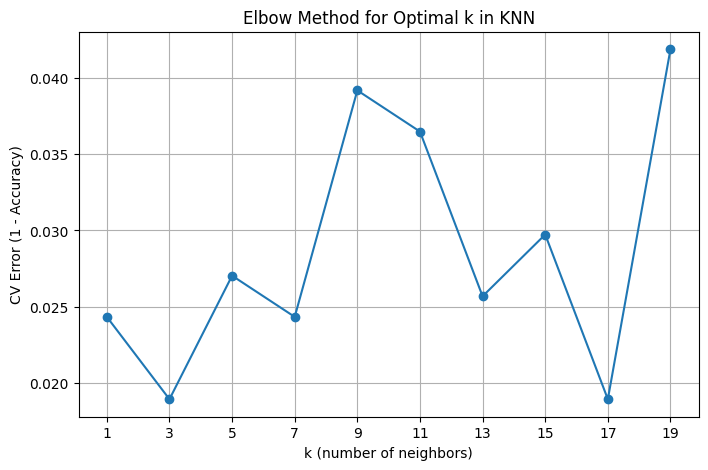

In [25]:
def knn_error_for_k(X, y, k_values, n_splits=5, weighted=True):
    errors = []
    for k in k_values:
        metrics = k_fold_cross_validation(X, y, k_neighbors=k, n_splits=n_splits, weighted=weighted)
        error = 1 - metrics['Accuracy']  # error rate
        errors.append(error)
        print(f"k={k}, CV Error={error:.3f}")
    return errors

k_values = range(1, 21, 2)
cv_errors = knn_error_for_k(X, y, k_values, n_splits=5)

plt.figure(figsize=(8,5))
plt.plot(k_values, cv_errors, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('CV Error (1 - Accuracy)')
plt.title('Elbow Method for Optimal k in KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()